In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem, mode
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io
import glob
import pandas as pd

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_244'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
later_path = '/oak/stanford/groups/trc/data/Ilana/2P/data/later/'
# func_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/'


In [3]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path,'func_0', 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

# *100 puts in units of 10ms, which will match fictrac
st_10ms = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times))]

# get 1ms version to match neural timestamps
st_ms= [i*10 for i in st_10ms]
starts_loom = st_10ms

loading photodiode data... done


In [4]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'func_0', 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX', 'speed']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'dRotLabX': short = 'X'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [5]:
fictrac_raw.keys()

Index(['frameCounter',     'dRotCamX',     'dRotCamY',     'dRotCamZ',
          'dRotScore',     'dRotLabX',     'dRotLabY',     'dRotLabZ',
         'AbsRotCamX',   'AbsRotCamY',   'AbsRotCamZ',   'AbsRotLabX',
         'AbsRotLabY',   'AbsRotLabZ',    'positionX',    'positionY',
            'heading',   'runningDir',        'speed',  'integratedX',
        'integratedY',    'timeStamp',     'sequence',             23,
                   24],
      dtype='object')

In [6]:
def smooth_vel(X, Y, theta):
    # Alex smooth
    N = np.size(X)
    
    Fwd = np.zeros((N), dtype=float)
    Slid = np.zeros((N), dtype=float)
    
    for i in range(1,N):
        dx = X[i]-X[i-1]
        dy = Y[i]-Y[i-1]
        tz = theta[i-1]
        Fwd[i] = dx*np.cos(tz) + dy*np.sin(tz)
        Slid[i] = dx*np.sin(tz) - dy*np.cos(tz)
    return Fwd, Slid

In [7]:
def orth_trans(RotX, RotY, RotZ):
    wx = np.mean(RotX)
    wy = np.mean(RotY)
    wz = np.mean(RotZ)
    w = np.linalg.norm([wx,wy,wz],2)

In [8]:
def smooth_and_interp_fictrac(fictrac, fps, resolution, expt_len, behavior, timestamps=None, smoothing=25, z=None):

    ### get orginal timestamps ###
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    x_original = np.arange(0,expt_len,camera_rate)

    ### smooth ###
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac[behavior]),smoothing,3)

    ### interpolate ###
    fictrac_interp_temp = scipy.interpolate.interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    if timestamps is None:
      fictrac_interp = fictrac_interp_temp(xnew)
    else:
      fictrac_interp = fictrac_interp_temp(timestamps[:,z])

    ### convert units for common cases ###
    sphere_radius = 4.5e-3 # in m
    if behavior in ['dRotLabY']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        
        fictrac_interp = fictrac_interp * sphere_radius * fps * 1000 # now in mm/sec
        
    if behavior in ['dRotLabZ']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        
        fictrac_interp = fictrac_interp * 180 / np.pi * fps
    
    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [9]:
sphere_radius = 4.5e-3 # in m
fps = 100

In [10]:
raw_head = pd.DataFrame.to_numpy(fictrac_raw['heading'])
raw_head = raw_head* 180 / np.pi * fps
raw_rot = pd.DataFrame.to_numpy(fictrac_raw['dRotLabZ'])
raw_rot = raw_rot* 180 / np.pi * fps
raw_rot_smooth = scipy.signal.savgol_filter(np.asarray(raw_rot),25,3)
raw_fwd = pd.DataFrame.to_numpy(fictrac_raw['dRotLabY'])
raw_fwd2 = raw_fwd * sphere_radius * fps * 1000
raw_fwd2_smooth = scipy.signal.savgol_filter(np.asarray(raw_fwd2),25,3)
raw_fwd2_smooth_x = scipy.signal.savgol_filter(np.asarray(raw_fwd2),505,3)
# camera_rate = 1/fps * 1000 # camera frame rate in ms
# x_original = np.arange(0,expt_len,camera_rate)
# fictrac_interp_temp = scipy.interpolate.interp1d(x_original, raw_fwd2_smooth, bounds_error = False)
# xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
# fictrac_interp = fictrac_interp_temp(xnew)

In [11]:
fwd_t, slid_t=smooth_vel(raw_fwd2_smooth, raw_rot_smooth, raw_head)

In [12]:
# threshold = -10
# raw_fwd2_smooth[raw_fwd2_smooth<threshold]=0

In [13]:
np.shape(fictrac_timestamps)

(180000,)

In [14]:
# fig, ax = plt.subplots(figsize=(20,10))
# plt.plot(raw_fwd2);
# plt.plot(raw_fwd2_smooth);
# plt.plot(raw_fwd2_smooth_x);
# s = 102000
# e = 110000
# fig, ax = plt.subplots(figsize=(20,10))
# plt.plot(raw_fwd2_smooth[s:e]);
# for i in range(len(actual_looms)):
#     if actual_looms[i]>=s and actual_looms[i]<=e:
#         plt.axvline(actual_looms[i]-s, color='r')
# fig, ax = plt.subplots(figsize=(20,10))
# plt.plot(raw_fwd2_smooth_x[s:e]);
# for i in range(len(actual_looms)):
#     if actual_looms[i]>=s and actual_looms[i]<=e:
#         plt.axvline(actual_looms[i]-s, color='r')

In [15]:
val = raw_fwd2_smooth_x
max_val = np.max(val)
min_val = np.min(val)
mean_val = np.mean(val)
median = np.median(val)
print('{}: Max is {}. Min is {}. Mean is {}. Median = {}.'.format(fly_num, max_val, min_val, mean_val, median))

fly_244: Max is 6.027319164929667. Min is -2.2607117270933075. Mean is 0.759792427052754. Median = 0.35647081855763363.


In [16]:
def extract_traces(fictrac, stim_times, pre_window, post_window, val=None):
    traces = []
    for i in range(len(stim_times)):
        if val != None:
            trace = fictrac[val][stim_times[i]-pre_window:stim_times[i]+post_window]
        else:
            trace = fictrac[stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

In [17]:
#next two cells made for 10min fictrac cut off

weird_size = np.size(fictrac['Y'])
weird_idx = list(np.where(np.asarray(starts_loom) <= weird_size)[0])
actual_looms = np.asarray(starts_loom)[weird_idx]

actual_looms_ms = [i*10 for i in actual_looms]

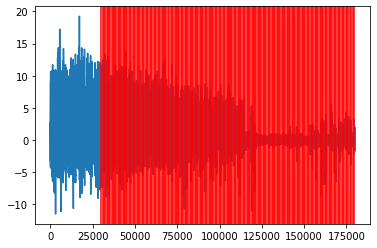

In [18]:
plt.plot(fictrac['Y'])
for i in range(len(actual_looms)):
    plt.axvline(actual_looms[i], color='r')
# plt.xlim(starts_loom[0], starts_loom[10])

In [19]:
max_val = np.max(fictrac['Y'])
min_val = np.min(fictrac['Y'])
mean_val = np.mean(fictrac['Y'])
print('{}: Max is {}. Min is {}. Mean is {}'.format(fly_num, max_val, min_val, mean_val))

fly_244: Max is 19.2537423979281. Min is -11.529556884975552. Mean is 0.7597986756083271


In [20]:
#QC to check if flies actually responding to loom
max_time = np.max(actual_looms)
min_time = 0
null_times = np.random.randint(min_time, max_time, len(actual_looms))
# this replaces starts_loom

In [21]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300
# avg_around = 20
stim_time = 100
# window = np.arange(-pre_window,post_window)

behavior_traces = {}
mean_trace = {}
sem_trace = {}
behavior_traces,mean_trace,sem_trace = extract_traces(fictrac['Y'], actual_looms, pre_window, post_window)
behavior_traces_QC,mean_trace_QC,sem_trace_QC = extract_traces(fictrac['Y'], null_times, pre_window, post_window)
bt,mt,st = extract_traces(fwd_t, actual_looms, pre_window, post_window)

In [22]:
def plot_trace(behavior_trace, pre_window, post_window, stim_time):
    mean_trace = np.mean(behavior_trace, axis=0)
    sem_trace = scipy.stats.sem(behavior_trace, axis=0)
    
    plt.figure(figsize=(10,10))
    plt.plot(mean_trace,color='k',linewidth=3)
    plt.fill_between(np.arange(len(mean_trace)),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
    plt.axvline(pre_window,color='k',linestyle='--',lw=2)
    plt.axvline(pre_window+stim_time,color='k',linestyle='--',lw=2)
    plt.ylim(-0.5, 3.5);

In [23]:
np.shape(behavior_traces)

(199, 500)

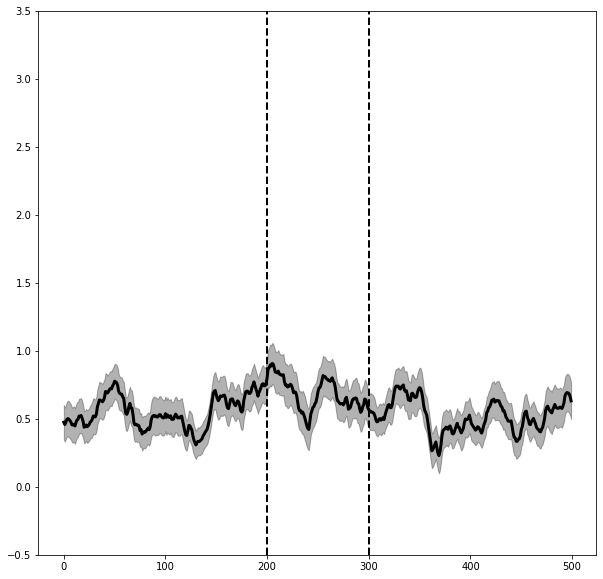

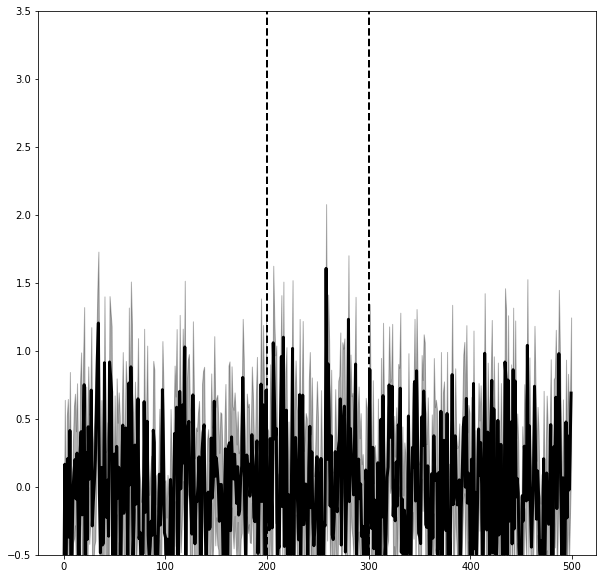

In [24]:
plot_trace(behavior_traces, pre_window, post_window, stim_time)
# plot_trace(behavior_traces_QC, pre_window, post_window, stim_time)
plot_trace(bt, pre_window, post_window, stim_time)
#null_hypothesis check
# plt.plot(mean_trace_QC,color='b',linewidth=3)
# plt.fill_between(np.arange(len(mean_trace_QC)),mean_trace_QC-sem_trace_QC, mean_trace_QC+sem_trace_QC, color='b',alpha=0.3)

In [25]:
ts = fictrac_raw["timeStamp"] #in ns i think
ts_sec = ts/1e9
fr = 1/np.mean(np.diff(ts_sec)) #figure out frame_rate from bruker fictrac

In [26]:
fr

100.00032328062332

In [27]:
# andrew anaylsis
value_struct ={
    # the data is in 10ms, use this value to get the index if i use seconds
    "tp_width_sec": 0.01,
    "trial_time_sec": 1,
    "before_stim_sec": pre_window/100,
    # time in seconds between end of pre trial window and the stimulus time. 
    # when set to zero, the pre trial window ends when the stimulus is presented
    "pre_trial_window_sec": 0.01,
    # size of window that pre trial speed is averaged over, seconds, window ends at stimulus time
    # when 0 is a single val and not a window
    "pre_trial_size_sec": 0.5,
    # size of post trial speed average window, sec
    "post_trial_window_sec": 0.5,
    # post trial window at stim tiem + post trail delay
    # when 0 is a single val and not a window
    "post_trial_size_sec": 0.1,
    "thresh": 0.05
    }

In [28]:
def get_vals_for_analysis(tp_width_sec=0, trial_time_sec=0, before_stim_sec=0, pre_trial_window_sec=0, pre_trial_size_sec=0, post_trial_window_sec=0, post_trial_size_sec=0, thresh=0):
        
    stim_end_sec = before_stim_sec + trial_time_sec
    
    stim_idx = int(before_stim_sec/tp_width_sec)
    stim_end_idx = int(stim_end_sec/tp_width_sec)
    pre_trial_window_idx = int(pre_trial_window_sec/tp_width_sec)

    # first val i use to make delta to compare change in vel
    first_val_end_idx = int(stim_idx - pre_trial_window_idx)
    first_val_start_idx = int(first_val_end_idx - (pre_trial_size_sec/tp_width_sec)) #only needed if you're averaging across a window, otherwise just start val is used

    # second val used to make delta
    second_val_start_idx = int(stim_idx + post_trial_size_sec/tp_width_sec)
    second_val_end_idx = int(second_val_start_idx + post_trial_window_sec/tp_width_sec)
    return stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx

In [29]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, method="gust")
    return y

In [30]:
def apply_butter_lowpass(behavior_traces, stim_idx, fr):
    # Filter requirements.
    order = 4
    fs = fr      # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = freqz(b, a, fs=fs, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(w, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    # plt.grid()

    # Filter the data, and plot both the original and filtered signals.
    lpf_behavior = np.zeros((behavior_traces.shape[0], behavior_traces.shape[1] - stim_idx))

    for i in range(behavior_traces.shape[0]):
        lpf_behavior[i, :] = butter_lowpass_filter(behavior_traces[i,stim_idx:], cutoff, fs, order)

    plt.subplot(2, 1, 2)
    plt.plot(np.mean(behavior_traces[:, stim_idx:], axis=0), 'b-', label='data')
    plt.plot(np.mean(lpf_behavior, axis=0), 'g-', linewidth=2, label='filtered data')
    # plt.plot(np.mean(lpf_behavior_QC, axis=0), 'r-', linewidth=2, label='QC filtered data')
    plt.xlabel('Time')
    # plt.grid()
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()
    return lpf_behavior

In [31]:
def get_speed_change(behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx):
    pre_tsi= first_val_start_idx-stim_idx
    pre_tei = first_val_end_idx-stim_idx
    post_tsi = second_val_start_idx-stim_idx
    post_tei = second_val_end_idx-stim_idx
    
    if first_val_start_idx!=first_val_end_idx:
        first_speed = np.mean(behavior[:,pre_tsi:pre_tei], axis = 1)
    else:
        first_val_start_idx = int(first_val_start_idx)
        first_speed = np.asarray(behavior[:,pre_tsi])

    if second_val_start_idx!=second_val_end_idx:
        second_speed = np.mean(behavior[:,post_tsi:post_tei], axis = 1)
    else: 
        second_speed = np.asarray(behavior[:,post_tsi])
    speed_change = second_speed-first_speed
    return speed_change

In [32]:
def get_trials(speed_change, thresh):
    decrease_trials = speed_change <-thresh
    decrease_idx = np.where(decrease_trials)
    increase_trials = speed_change>thresh
    increase_idx = np.where(increase_trials)
    flat_trials = np.logical_and(speed_change>-thresh, speed_change<thresh)
    flat_idx = np.where(flat_trials)
    return increase_trials, decrease_trials, flat_trials

In [33]:

def validate_trial(trial_idx, trace=None):
    """ Visualize a single trial, along with the pre and post averaging windows
    
    RED: pre window
    YELLOW: post window
    BLUE: stim time
    """
    if trace is None:
        trace = behavior_traces[trial_idx]
    plt.plot(trace)
    plt.axvline(first_val_start_idx, color='r')
    plt.axvline(first_val_end_idx, color='r')
    plt.axvline(second_val_start_idx, color='y')
    plt.axvline(second_val_end_idx, color='y')
    plt.axvline(stim_idx, color='b')


def validate_windows(behavior_traces, value_struct, fr):
    """ Visualize average traces for both slow and fast trials
    
    NOTE: uses global variables, must rerun constant cells and slow_ind logic to change results.
    
    RED: pre window
    YELLOW: post window
    BLUE: stim time
    """
    
    stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx = get_vals_for_analysis(**value_struct)
    lpf_behavior = apply_butter_lowpass(behavior_traces, stim_idx, fr)
    speed_change = get_speed_change(lpf_behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx)
    increase_trials, decrease_trials, flat_trials = get_trials(speed_change, value_struct["thresh"])
    increase_traces = behavior_traces[increase_trials]
    decrease_traces = behavior_traces[decrease_trials]
    flat_traces = behavior_traces[flat_trials]
    
    print(f"{len(increase_traces)} increase trials")
    print(f"{len(decrease_traces)} decrease trials")
    print(f"{len(flat_traces)} flat trials")
    
    increase_mean = np.mean(increase_traces, axis=0)
    increase_sem = scipy.stats.sem(increase_traces, axis=0)
    
    decrease_mean = np.mean(decrease_traces, axis=0)
    decrease_sem = scipy.stats.sem(decrease_traces, axis=0)
    
    flat_mean = np.mean(flat_traces, axis=0)
    flat_sem = scipy.stats.sem(flat_traces, axis=0)
    
    fig, axes = plt.subplots(nrows=3)
    
    axes[0].plot(increase_mean, color='k',linewidth=3)
    axes[0].set_ylim(-1, 3.5)
    axes[0].fill_between(np.arange(len(increase_mean)), increase_mean - increase_sem, increase_mean + increase_sem, color='k',alpha=0.3)
    axes[0].axvline(first_val_start_idx, color='r')
    axes[0].axvline(first_val_end_idx, color='r')
    axes[0].axvline(second_val_start_idx, color='y')
    axes[0].axvline(second_val_end_idx, color='y')
    axes[0].axvline(stim_idx, color='b', linestyle='--')
    axes[0].axvline(stim_end_idx, color='b', linestyle='--')
#     axes[0].set_title("slow trials")
    

    
    axes[1].plot(decrease_mean, color='k',linewidth=3)
    axes[1].set_ylim(-1, 3.5)
    axes[1].fill_between(np.arange(len(decrease_mean)), decrease_mean - decrease_sem, decrease_mean + decrease_sem, color='k',alpha=0.3)
    axes[1].axvline(first_val_start_idx, color='r')
    axes[1].axvline(first_val_end_idx, color='r')
    axes[1].axvline(second_val_start_idx, color='y')
    axes[1].axvline(second_val_end_idx, color='y')
    axes[1].axvline(stim_idx, color='b', linestyle='--')
    axes[1].axvline(stim_end_idx, color='b', linestyle='--')
    
    axes[2].plot(flat_mean, color='k',linewidth=3)
    axes[2].set_ylim(-1, 3.5)
    axes[2].fill_between(np.arange(len(flat_mean)), flat_mean - flat_sem, flat_mean + flat_sem, color='k',alpha=0.3)
    axes[2].axvline(first_val_start_idx, color='r')
    axes[2].axvline(first_val_end_idx, color='r')
    axes[2].axvline(second_val_start_idx, color='y')
    axes[2].axvline(second_val_end_idx, color='y')
    axes[2].axvline(stim_idx, color='b', linestyle='--')
    axes[2].axvline(stim_end_idx, color='b', linestyle='--')
    
    return fig, axes


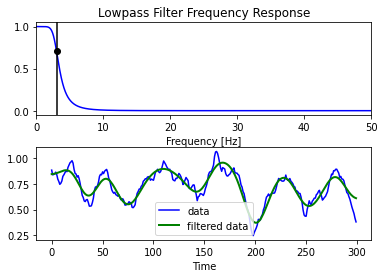

85 increase trials
81 decrease trials
33 flat trials


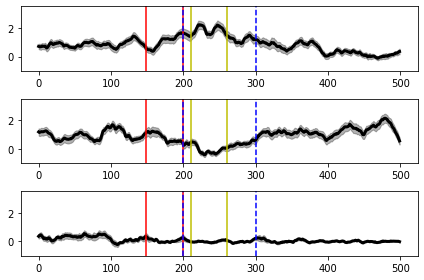

In [34]:
fig, axes = validate_windows(behavior_traces_QC,value_struct, fr)
fig.tight_layout()

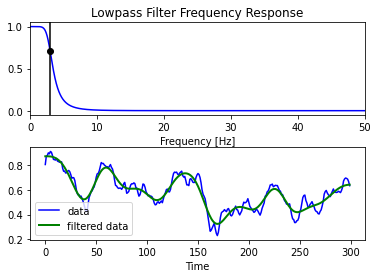

86 increase trials
66 decrease trials
47 flat trials


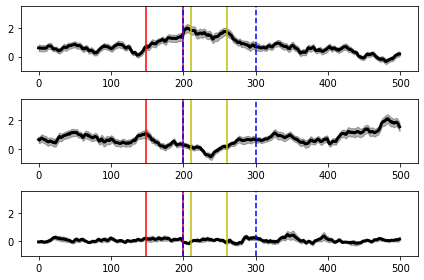

In [35]:
fig, axes = validate_windows(behavior_traces, value_struct, fr)
fig.tight_layout()

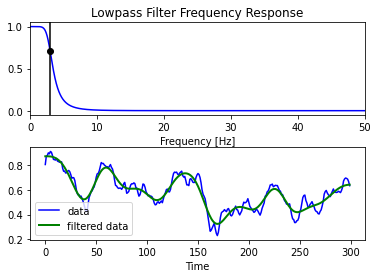

In [36]:
stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx = get_vals_for_analysis(**value_struct)
lpf_behavior = apply_butter_lowpass(behavior_traces, stim_idx, fr)
speed_change = get_speed_change(lpf_behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx)
increase_trials, decrease_trials, flat_trials = get_trials(speed_change, value_struct["thresh"])
increase_traces = behavior_traces[increase_trials]
decrease_traces = behavior_traces[decrease_trials]
flat_traces = behavior_traces[flat_trials]

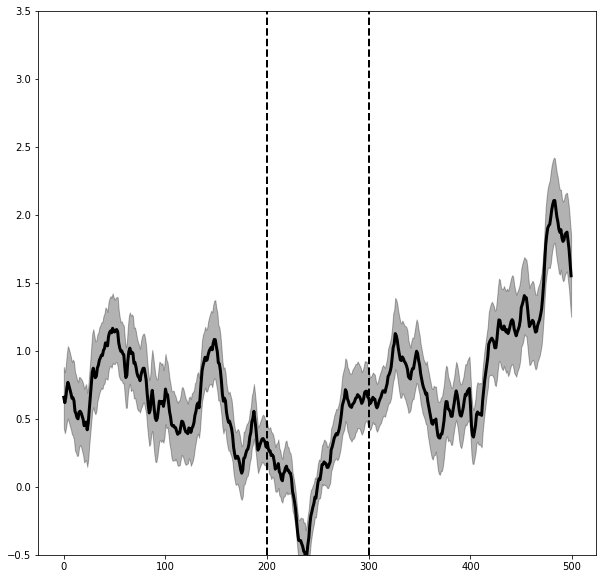

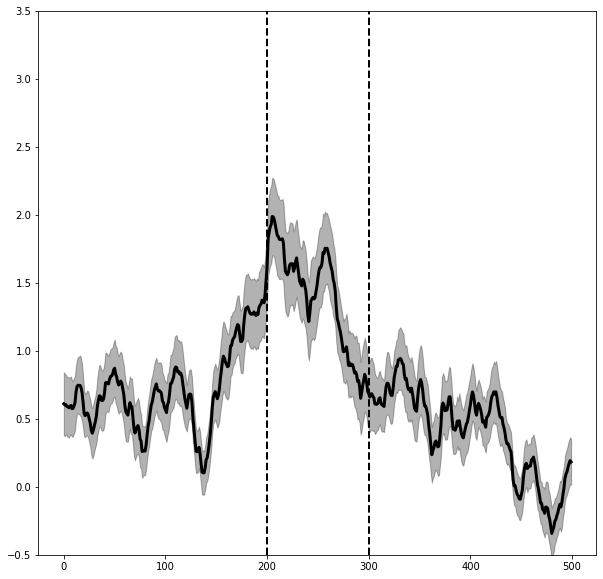

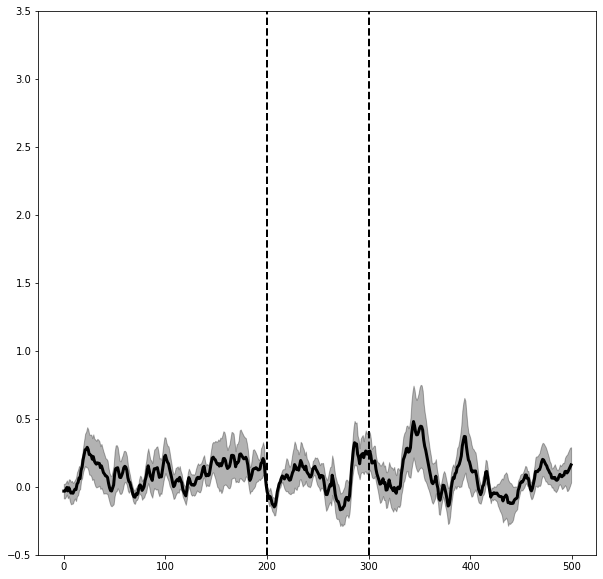

In [37]:
plot_trace(decrease_traces, pre_window, post_window, stim_time)
# print(np.shape(decrease_traces))
plot_trace(increase_traces, pre_window, post_window, stim_time)
# print(np.shape(increase_traces))
plot_trace(flat_traces, pre_window, post_window, stim_time)
# print(np.shape(flat_traces))

In [38]:
def split_to_type(behave, thresh_val):
    divided_behave = {"greater":{},"less":{}, "weird":{}}
    weird = np.where(np.count_nonzero(behave[:, :200]<-1, axis=1)>10)
    divided_behave['weird'] = behave[weird]
    wcount = np.shape(weird)[1]
    print('weird: {}'.format(wcount))
    greater = np.where(np.mean(behave[:, :200], axis=1)>thresh_val)
    greater = np.asarray(list(set(greater[0])-set(weird[0])))
    if greater.size>0:
        divided_behave['greater'] = behave[greater]
        gcount = np.shape(greater)[0]
    else:
        gcount = 0
    print('greater: {}'.format(gcount))
    less = np.where(np.mean(behave[:, :200], axis=1)<=thresh_val)
    less = np.asarray(list(set(less[0])-set(weird[0])))
#     print(less)
    if less.size>0:
        divided_behave['less'] = behave[less]
        lcount = np.shape(less)[0]
    else:
        lcount=0
    print('less: {}'.format(lcount))
    return divided_behave

In [39]:
thresh_val = 3
divided_behave = split_to_type(behavior_traces, thresh_val)

weird: 60
greater: 0
less: 139


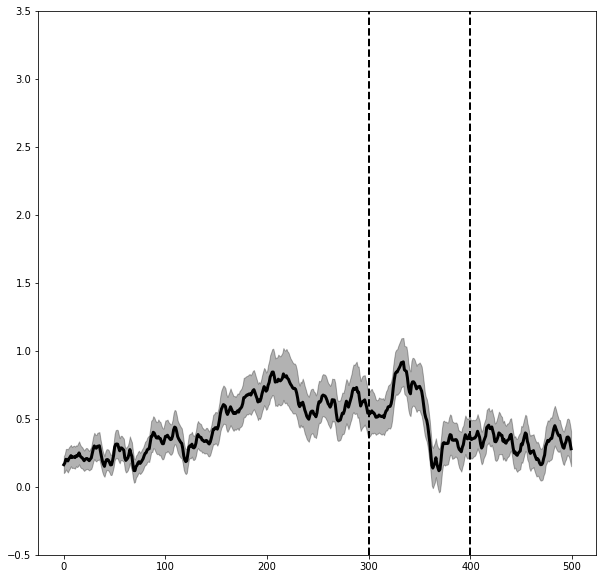

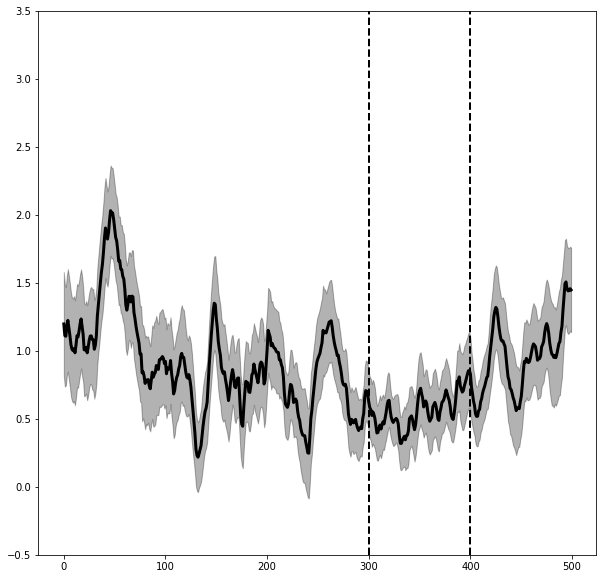

In [40]:
# plot_trace(divided_behave['greater'],post_window, pre_window, stim_time)
# total = np.concatenate(divided_behave['less'], divided_behave['greater'])
# print(np.shape(total))
plot_trace(divided_behave['less'],post_window, pre_window, stim_time)
plot_trace(divided_behave['weird'],post_window, pre_window, stim_time)

# load neural

In [41]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'func_0','clustering')

ch_num = '2'#'1'#
label_name =''
signal_name =''

for x in sorted(os.listdir(cluster_dir)):
    if 'label' in x and ch_num in x:
        label_name = x
    if 'signals' in x and ch_num in x:
        signal_name = x
    elif 'signals' in x:
        signal_name = x
    elif 'label' in x:
        label_name = x

print(label_name)
print(signal_name)
        
load_file = os.path.join(cluster_dir, label_name)
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, signal_name)
all_signals = np.load(load_file)

cluster_labels_1.npy
cluster_signals_1.npy


In [42]:
np.shape(all_signals)

(49, 2000, 3384)

In [43]:
time_average =np.mean(all_signals, axis=(0,1))

# Fictrac checks

In [44]:
fictrac['Y'] = np.squeeze(fictrac['Y'])
out = scipy.signal.correlate(time_average, fictrac['Y'])

(3300.0, 3400.0)

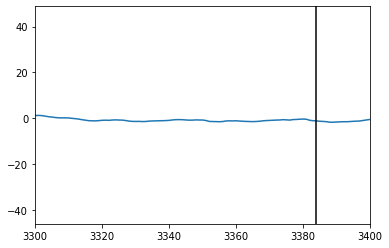

In [45]:
plt.plot(out)
plt.axvline(3384,color='k')
plt.xlim(3300,3400)

# check warp quality

In [46]:
fixed = brainsss.load_fda_meanbrain()

In [47]:
fixed

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [48]:
atlas = brainsss.load_roi_atlas()

In [49]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [50]:
timestamps = brainsss.load_timestamps(os.path.join(func_path,'func_0', 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [51]:
warp_dir = os.path.join(func_path, 'warp')
f2a = ants.image_read(os.path.join(warp_dir, 'func-to-anat.nii'))

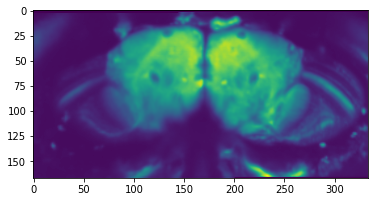

In [52]:
plt.imshow(f2a[:,:,50].T)

In [53]:
a2a = ants.image_read(os.path.join(warp_dir, 'anat-to-meanbrain.nii'))

In [54]:
a2a

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [55]:
anat_dir = os.path.join(func_path, 'anat_0', 'moco')
anat = ants.image_read(os.path.join(anat_dir, 'anatomy_channel_1_moc_mean.nii'))

In [56]:
anat.set_spacing((0.653, 0.653, 1))

In [57]:
anat_low=anat.resample_image((2,2,2),use_voxels=False)

In [58]:
np.shape(a2a)

(314, 146, 91)

In [59]:
a2a.dtype

'float32'

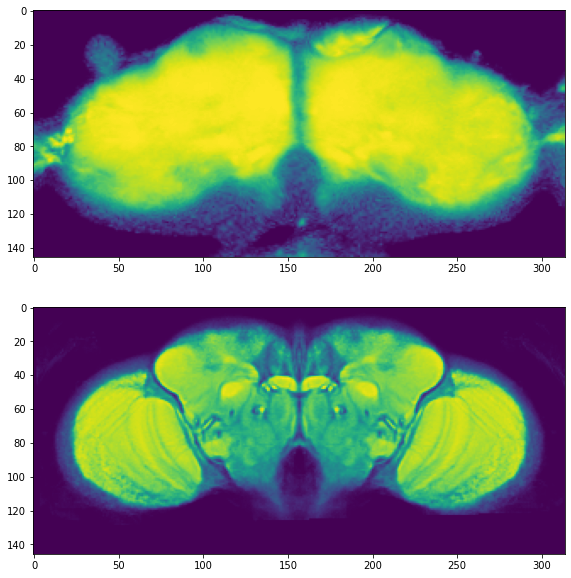

In [60]:
z=20
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(a2a[:,:,z].T)
plt.subplot(2,1,2)
plt.imshow(fixed[:,:,z].T)

# STA wrapped

In [61]:
bin_start = -500; bin_end = 2000; bin_size = 100 #ms
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [62]:
####CHANGE BEHAVIOR!!!
behavior_traces = behavior_traces
# behavior_traces = behavior_traces_QC

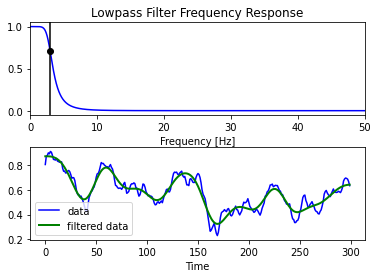

In [63]:
stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx = get_vals_for_analysis(**value_struct)
lpf_behavior = apply_butter_lowpass(behavior_traces, stim_idx, fr)
speed_change = get_speed_change(lpf_behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx)
increase_trials, decrease_trials, flat_trials = get_trials(speed_change, value_struct["thresh"])

In [64]:
def get_event_times_list(trials, event_times, ms=True):
    trials_idx = np.where(trials)
    trials_starts =[]
    for idx in trials_idx[0]:
        trials_starts.append(event_times[idx])
    if ms==True:
        trials_starts = [n*10 for n in trials_starts]
    print(np.shape(trials_starts))
    return trials_starts

In [65]:
# For regular data
decrease_starts_ms = get_event_times_list(decrease_trials, actual_looms, ms=True)
increase_starts_ms = get_event_times_list(increase_trials, actual_looms, ms=True)
flat_starts_ms = get_event_times_list(flat_trials, actual_looms, ms=True)

# # For QC data
# decrease_starts_ms = get_event_times_list(decrease_trials, null_times, ms=True)
# increase_starts_ms = get_event_times_list(increase_trials, null_times, ms=True)
# flat_starts_ms = get_event_times_list(flat_trials, null_times, ms=True)


(66,)
(86,)
(47,)


In [66]:
actual_looms_ms = [n*10 for n in actual_looms]
null_times_ms = [n*10 for n in null_times]

In [67]:
t0 = time.time()
STA_brain_decrease = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = decrease_starts_ms,
                                   neural_bins = neural_bins)

STA_brain_increase = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = increase_starts_ms,
                                   neural_bins = neural_bins)

STA_brain_flat = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = flat_starts_ms,
                                   neural_bins = neural_bins)

STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = actual_looms_ms,#null_times_ms, 
                                   neural_bins = neural_bins)
print(F'STA {time.time()-t0}')

STA 4.381178140640259


In [68]:
np.shape(all_signals)

(49, 2000, 3384)

In [69]:
np.shape(STA_brain)

(49, 24, 2000)

In [70]:
STA_brain_decrease = np.nan_to_num(STA_brain_decrease)
STA_brain_increase = np.nan_to_num(STA_brain_increase)
STA_brain_flat = np.nan_to_num(STA_brain_flat)
STA_brain = np.nan_to_num(STA_brain)

In [71]:
np.shape(STA_brain)

(49, 24, 2000)

In [72]:
reformed_STA_brain_decrease = brainsss.STA_supervoxel_to_full_res(STA_brain_decrease, cluster_labels)
reformed_STA_brain_increase = brainsss.STA_supervoxel_to_full_res(STA_brain_increase, cluster_labels)
reformed_STA_brain_flat = brainsss.STA_supervoxel_to_full_res(STA_brain_flat, cluster_labels)
reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)

In [73]:
np.shape(reformed_STA_brain)

(49, 24, 256, 128)

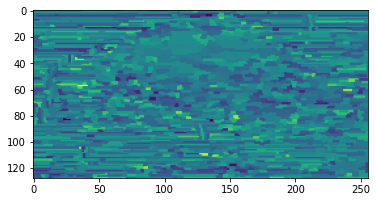

In [74]:
plt.imshow(reformed_STA_brain[25,13,:,:].T,)

In [75]:
#change the STA brain based on condition
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)

In [76]:
STA_brain.dtype

dtype('float64')

In [77]:
print(np.shape(STA_brain))
np.shape(np.rollaxis(STA_brain[:,0,:,:],0,3))

(49, 24, 256, 128)


(256, 128, 49)

In [78]:
# sta_save = np.moveaxis(STA_brain, [2, 3, 0, 1], [0, 1, 2, 3])
# np.shape(sta_save)

In [79]:
# movie_dir = os.path.join(func_path, 'movies')
# if os.path.exists(movie_dir)==False:
#     os.mkdir(movie_dir)
# print(movie_dir)
# movie_dir = os.path.join(func_path, 'movies')
# nib.Nifti1Image(sta_save, np.eye(4)).to_filename(os.path.join(movie_dir, 'test' + '.nii'))

In [80]:
## STA_brain will be (bins,x,t,z) or (20,256,128,49)
#what you want now is (n,256,128,49), where n is number of looms

In [81]:
def warp_STA_brain(STA_brain, fly, fixed, anat_to_mean_type, func_path):
    n_tp = STA_brain.shape[1]
    moving_resolution = (2.611, 2.611, 5)
    ###########################
    ### Organize Transforms ###
    ###########################
    warp_directory = os.path.join(func_path,'warp')
    warp_sub_dir = 'func-to-anat_fwdtransforms_2umiso'
    affine_file = os.listdir(os.path.join(warp_directory, warp_sub_dir))[0]
    affine_path = os.path.join(warp_directory, warp_sub_dir, affine_file)
    if anat_to_mean_type == 'myr':
        warp_sub_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
    elif anat_to_mean_type == 'non_myr':
        warp_sub_dir = 'anat-to-non_myr_mean_fwdtransforms_2umiso'
    else:
        print('invalid anat_to_mean_type')
        return
    syn_files = os.listdir(os.path.join(warp_directory, warp_sub_dir))
    syn_linear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.mat' in x][0])
    syn_nonlinear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.nii.gz' in x][0])
    ####transforms = [affine_path, syn_linear_path, syn_nonlinear_path]
    transforms = [syn_nonlinear_path, syn_linear_path, affine_path] ### INVERTED ORDER ON 20220503!!!!
    #ANTS DOCS ARE SHIT. THIS IS PROBABLY CORRECT, AT LEAST IT NOW WORKS FOR THE FLY(134) THAT WAS FAILING


    ### Warp timeponts
    warps = []
    for tp in range(n_tp):
        to_warp = np.rollaxis(STA_brain[:,tp,:,:],0,3)
        moving = ants.from_numpy(to_warp)
        moving.set_spacing(moving_resolution)
        ########################
        ### Apply Transforms ###
        ########################
        moco = ants.apply_transforms(fixed, moving, transforms)
        warped = moco.numpy()
        warps.append(warped)

    return warps

In [82]:
t0 = time.time()
warps = warp_STA_brain(STA_brain=STA_brain, fly=fly_num, fixed=fixed, anat_to_mean_type='myr', func_path=func_path)
print(F'Warps {time.time()-t0}')

Warps 8.690951585769653


In [83]:
np.shape(warps)

(24, 314, 146, 91)

In [84]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [85]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[tp][:,:,::-1]
    vmax = 0.5 #this was 0.5 for STA <------------
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')

Explosion 25.229252576828003


In [86]:
def get_rois(explosion_rois, roi_group, roi_masks, data_to_plot, roi_contours, vmax, cmap, diverging, roi=None):
    x_shift = explosion_rois[roi_group]['x_shift']
    y_shift = explosion_rois[roi_group]['y_shift']

    roi_data = []
    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    if roi==None:
        for roi in explosion_rois[roi_group]['rois']:
            mask = roi_masks[roi]
            #masked_roi = mask[...,np.newaxis]*data_to_plot # for 3 channel
            masked_roi = mask*data_to_plot

            ### maximum projection along z-axis
            # works for negative values
            maxs = np.max(masked_roi,axis=2)
            mins = np.min(masked_roi,axis=2)
            maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
            roi_data.append(maxs)
            #masked_roi_flat = maxs

            ### maximum projection along z-axis
            #masked_roi_flat = np.max(masked_roi,axis=2)
            #roi_data.append(masked_roi_flat)

            left_edges.append(roi_contours[roi]['left_edge'])
            right_edges.append(roi_contours[roi]['right_edge'])
            top_edges.append(roi_contours[roi]['top_edge'])
            bottom_edges.append(roi_contours[roi]['bottom_edge'])
    else:
        mask = roi_masks[roi]
        #masked_roi = mask[...,np.newaxis]*data_to_plot # for 3 channel
        masked_roi = mask*data_to_plot

        ### maximum projection along z-axis
        # works for negative values
        maxs = np.max(masked_roi,axis=2)
        mins = np.min(masked_roi,axis=2)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
        roi_data.append(maxs)
        #masked_roi_flat = maxs

        ### maximum projection along z-axis
        #masked_roi_flat = np.max(masked_roi,axis=2)
        #roi_data.append(masked_roi_flat)

        left_edges.append(roi_contours[roi]['left_edge'])
        right_edges.append(roi_contours[roi]['right_edge'])
        top_edges.append(roi_contours[roi]['top_edge'])
        bottom_edges.append(roi_contours[roi]['bottom_edge'])


    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ### this projects across all the roi_data from each roi 
    #roi_datas = np.max(np.asarray(roi_data),axis=0) # this one line is sufficient for not diverging
    maxs = np.max(np.asarray(roi_data),axis=0)
    mins = np.min(np.asarray(roi_data),axis=0)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
    roi_datas = maxs

    ###ADD MAX MIN HERE LIKE ABOVE

    ### cutout this grouping
    #data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge,:],0,1) # for 3 channel
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    ### apply gain
    #data_map = data_map * gain

    mycmap = matplotlib.cm.get_cmap(cmap)
    #mycmap.set_bad('k',1) # make nans black

    if diverging:
        # this will normalize all value to [0,1], with 0.5 being the new "0" basically
        # current issue - a zero that should be background now looks like negative.
        # solution: could use nans instead and set bad color
        # with diverging we should make background white!
        # so actually just set the input_canvas as 0.5!!!
        # then make contours nan and set back as black
        norm = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)
        data_map = norm(data_map)
    else:
        data_map = data_map/vmax

    data_map = mycmap(data_map)[...,:3] #lose alpha channel

#     dims = get_dim_info(data_map, full_x_mid, full_y_mid)
    return data_map

In [87]:
vmax = 0.5 #this was 0.5 for STA <------------
data_map = get_rois(explosion_rois, 'PB', roi_masks, warps[5][:,:,::-1], roi_contours, vmax=vmax, cmap='seismic', diverging=True)

(21, 55, 3)


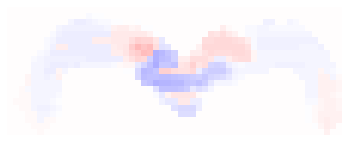

In [88]:
print(np.shape(data_map))
plt.imshow(data_map)
plt.axis('off');

In [230]:
movie_dir = os.path.join(func_path, 'movies')
if os.path.exists(movie_dir)==False:
    os.mkdir(movie_dir)
print(movie_dir)

/oak/stanford/groups/trc/data/Ilana/2P/data/fly_244/movies


In [231]:
save_dir = os.path.join(movie_dir,'total_channel2')
if os.path.exists(save_dir)==False:
    os.mkdir(save_dir)
print(save_dir)

/oak/stanford/groups/trc/data/Ilana/2P/data/fly_244/movies/total_channel2


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


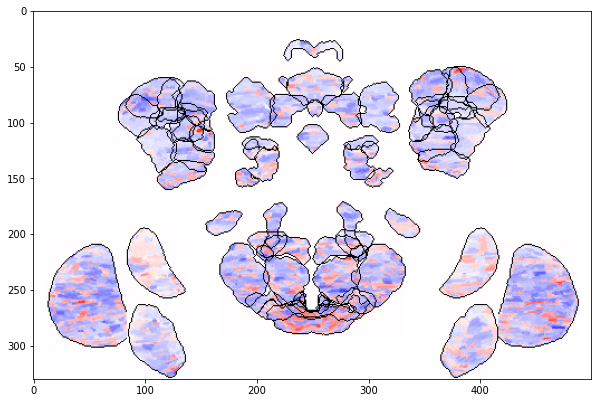

In [232]:
plt.figure(figsize=(10,10))
for i in range(24):
    print(i)
    plt.imshow(explosions[i][170:,:]) #this was made with cmap=hot
    plt.axis('off')
    fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')